# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

In [144]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yhzang32/physicsinformedlearning4pde")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\denni\.cache\kagglehub\datasets\yhzang32\physicsinformedlearning4pde\versions\2
Path to dataset files: C:\Users\denni\.cache\kagglehub\datasets\yhzang32\physicsinformedlearning4pde\versions\2


**DeepRitz Solution**

**MLP Architecture**

In [145]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        x = torch.tanh(x)
        x = torch.sin(x*torch.pi + torch.pi)
        return x

    def forward(self, x):
        x_pos = x.clone()
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return x*(1-x_pos)*x_pos


**E(x) definition**

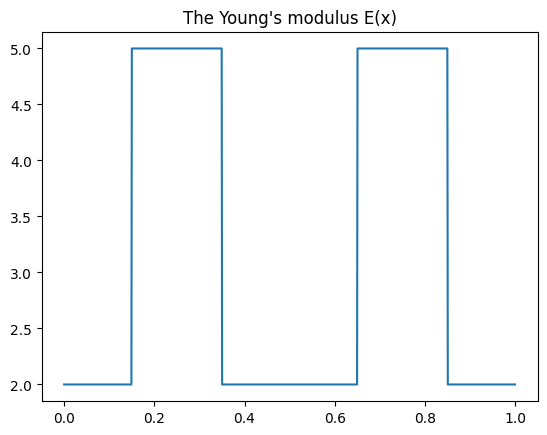

In [146]:
import numpy as np
import matplotlib.pyplot as  plt
import torch

def E(x, phase1=2., phase2=5.):
    '''Young's modulus'''
    return torch.where(torch.abs(x-0.5)<0.35, torch.where(torch.abs(x-0.5)>0.15, phase2, phase1), phase1)
#
x_plot = torch.linspace(0., 1., 1000).reshape(-1, 1)
e_plot = E(x_plot)
#
plt.figure()
plt.plot(x_plot.cpu().numpy(), e_plot.cpu().numpy())
plt.title("The Young's modulus E(x)")
plt.show()

**Testing Dataset Plot**

Keys in the dataset: ['u_test', 'x_test']
Shape of x_test: torch.Size([1001, 1])
Shape of u_test: torch.Size([1001, 1])


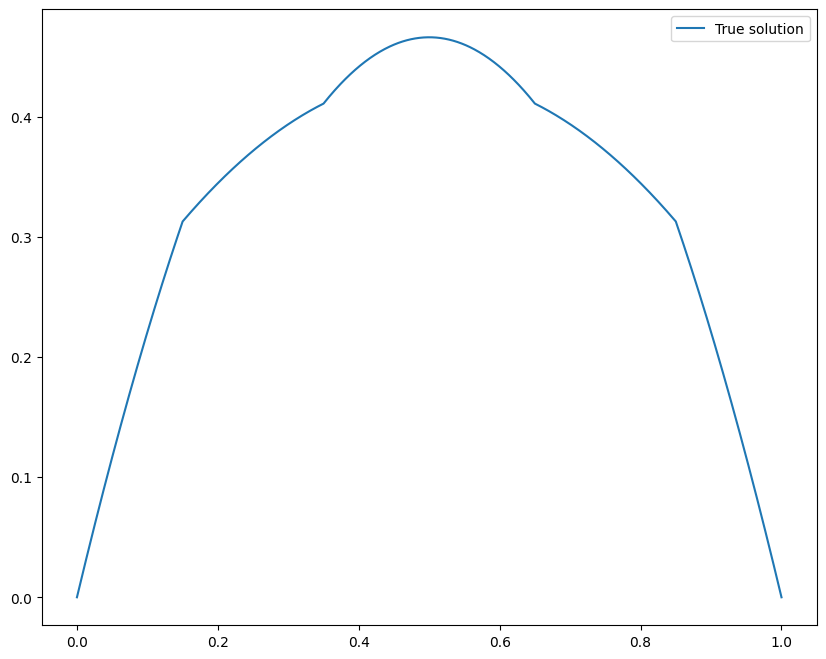

In [147]:
import h5py
import numpy as np
import torch
import os

elasticity_datasset = os.path.join(path, "LinearElasticity1d.h5")

with h5py.File(elasticity_datasset, "r") as f:
    # List all groups
    print("Keys in the dataset:", list(f.keys()))
    x_test = f["x_test"][:]
    u_test = f["u_test"][:]

x_test = x_test.reshape(-1, 1)
u_test = u_test.reshape(-1, 1)

x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_test = torch.tensor(u_test, dtype=torch.float32).to(device)

print("Shape of x_test:", x_test.shape)
print("Shape of u_test:", u_test.shape)

plt.figure(figsize=(10, 8))
plt.plot(x_test.cpu().numpy(), u_test.cpu().numpy(), label="True solution")
plt.legend()
plt.show()


**Loss Function**

In [148]:
from torch.autograd import grad, Variable

torch.manual_seed(1234)

class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
        self.getLoss = torch.nn.MSELoss()
    
    def loss_bd(self, x_bd, u_bd):
        '''loss term related to boundary condition'''
        ############## Loss term related to the boundary condition
        x = x_bd.to(self.device)
        u = self.u_model(x)
        loss = self.getLoss(u, u_bd.to(self.device))
        
        return loss 
        
    def loss_pde(self, x_int=None):
        '''loss term related to the PDE'''
        ################################# The integral points
        if x_int is None:
            x_int = np.random.uniform([0.], [1.], 10000).reshape(-1,1)
            x_int = torch.tensor(x_int, dtype=torch.float32)
        ################# The PDE loss
        x = Variable(x_int, requires_grad=True).to(self.device)
        #
        u = self.u_model(x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 9.81
        # The energy
        energy = torch.mean(0.5 * E(x) * du_dx**2 - f*u)
        
        return energy

    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))


**Training**

In [149]:
############ Training setups
from tqdm import trange

torch.manual_seed(1234)

epochs = 5000
lr = 1e-3
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/5), gamma=0.5)

x_bd, u_bd = torch.tensor(np.vstack([[0.], [1.]]), dtype=torch.float32), torch.tensor([[0.], [0.]], dtype=torch.float32)

w_pde = 2.
w_bd = 10.
############ The training process
error_list = []
for epoch in trange(epochs):
    lossClass = LossClass(model_u)
    ############# Calculate losses
    loss_bd = lossClass.loss_bd(x_bd, u_bd)
    loss_in = lossClass.loss_pde(x_int=None)
    loss_train = w_pde*loss_in + w_bd*loss_bd
    #
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    #
    with torch.no_grad():
        error = lossClass.get_error(x_test, u_test)
        error_list.append(error.item())
    #
    scheduler.step()  # Adjust learning rate
    if (epoch+1)%500==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_list.pop())

torch.save(model_u.state_dict(), 'model_u_task1.pth')
print("Model weights saved successfully.")

 10%|█         | 511/5000 [00:04<00:43, 103.14it/s]

Epoch:499, The loss is:-3.2981302738189697, lr: 0.001
0.014109194278717041


 20%|██        | 1011/5000 [00:09<00:37, 107.46it/s]

Epoch:999, The loss is:-3.1724977493286133, lr: 0.0005
0.013027911074459553


 30%|███       | 1513/5000 [00:13<00:25, 136.11it/s]

Epoch:1499, The loss is:-3.204801559448242, lr: 0.0005
0.012083301320672035


 40%|████      | 2025/5000 [00:17<00:21, 138.04it/s]

Epoch:1999, The loss is:-3.2321360111236572, lr: 0.00025
0.019083216786384583


 50%|█████     | 2520/5000 [00:21<00:18, 131.36it/s]

Epoch:2499, The loss is:-3.215817928314209, lr: 0.00025
0.005410563200712204


 60%|██████    | 3021/5000 [00:26<00:18, 106.88it/s]

Epoch:2999, The loss is:-3.25775146484375, lr: 0.000125
0.013412629254162312


 70%|███████   | 3516/5000 [00:30<00:13, 110.62it/s]

Epoch:3499, The loss is:-3.178436517715454, lr: 0.000125
0.0054425327107310295


 80%|████████  | 4019/5000 [00:35<00:08, 122.09it/s]

Epoch:3999, The loss is:-3.1687302589416504, lr: 6.25e-05
0.008688424713909626


 90%|█████████ | 4512/5000 [00:39<00:04, 121.21it/s]

Epoch:4499, The loss is:-3.271820306777954, lr: 6.25e-05
0.0035838212352246046


100%|██████████| 5000/5000 [00:43<00:00, 115.98it/s]

Epoch:4999, The loss is:-3.228076219558716, lr: 3.125e-05
0.0036047459580004215
Model weights saved successfully.


**Results**

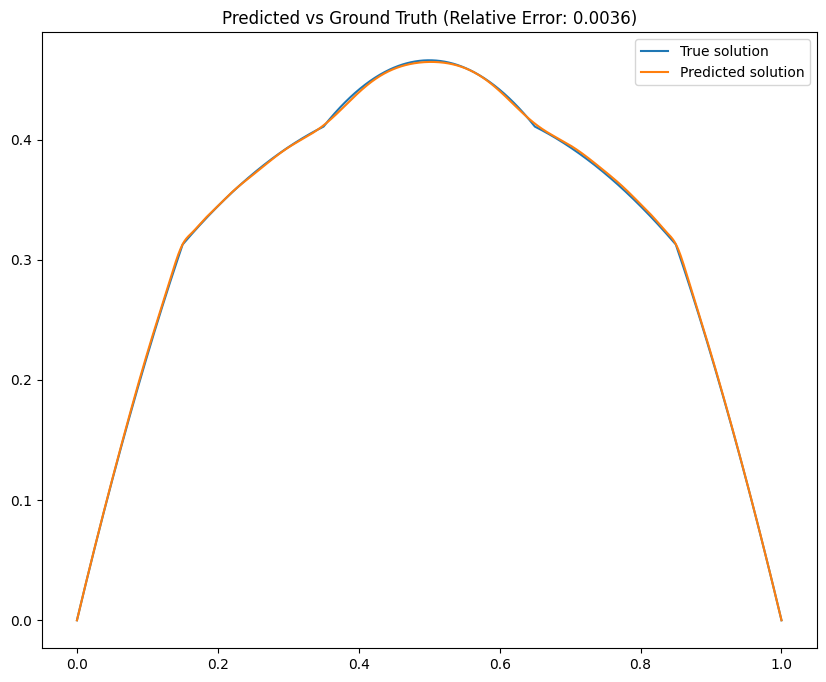

In [150]:
plt.figure(figsize=(10, 8))
plt.plot(x_test.cpu().numpy(), u_test.cpu().numpy(), label="True solution")

u_pred = model_u(x_test.to(device)).cpu().detach()
plt.plot(x_test.cpu().numpy(), u_pred.numpy(), label="Predicted solution")

plt.legend()
plt.title(f"Predicted vs Ground Truth (Relative Error: {error.item():.4f})")
plt.show()

## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors 
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

**Importing Dataset**

In [79]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yhzang32/physicsinformedlearning4pde")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\denni\.cache\kagglehub\datasets\yhzang32\physicsinformedlearning4pde\versions\2


**Observation Data & Training Set**

<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>
Shape of x_obs: (250, 1)
Shape of u_obs: (250, 1)
Shape of x_test: (1001, 1)
Shape of u_test: (1001, 1)
Shape of e_test: (1001, 1)


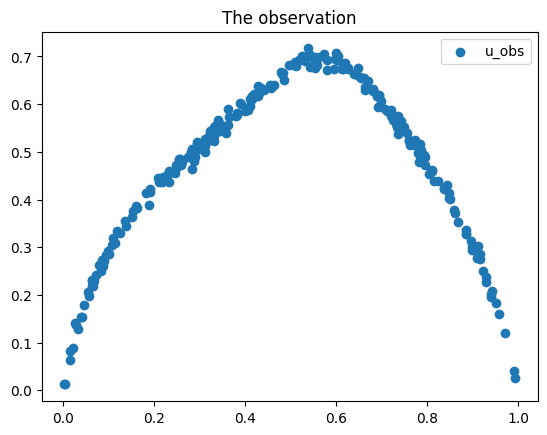

In [105]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

elasticity_datasset = os.path.join(path, "LinearElasticity1d_inverse.h5")

with h5py.File(elasticity_datasset, "r") as file:
    print(file.keys())
    #
    x_obs = np.array(file['x_obs']).reshape(-1,1)
    u_obs = np.array(file['u_obs']).reshape(-1,1)
    x_test = np.array(file['x_test']).reshape(-1,1)
    e_test = np.array(file['e_test']).reshape(-1,1)
    u_test = np.array(file['u_test']).reshape(-1,1)

print("Shape of x_obs:", x_obs.shape)
print("Shape of u_obs:", u_obs.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of u_test:", u_test.shape)
print("Shape of e_test:", e_test.shape)

x_obs = torch.tensor(x_obs, dtype=torch.float32).to(device)
u_obs = torch.tensor(u_obs, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
e_test = torch.tensor(e_test, dtype=torch.float32).to(device)
u_test = torch.tensor(u_test, dtype=torch.float32).to(device)

plt.figure()
plt.scatter(x_obs.cpu().numpy(), u_obs.cpu().numpy(), label='u_obs')
plt.title('The observation')
plt.legend()
plt.show()

np.random.seed(1234)
x_in = np.random.uniform([0.], [1.], 10000).reshape(-1,1)
x_in = torch.tensor(x_in, dtype=torch.float32).to(device)

**MLP Architecture**

In [106]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x
        
    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)
        return x

**Loss Function Definition**

In [134]:
from torch.autograd import grad, Variable

torch.manual_seed(1234)

class Mollifier(object):
    '''For capturing the boundary conditions.'''

    def apply_u(self, u, x):
        return u*(x*(1-x))

    def apply_e(self, e, x):
        e = torch.nn.functional.softplus(e)
        return e*(x*(1-x)) + 1

class LossClass(object):

    def __init__(self, u_model, e_model):
        self.device = device
        self.e_model = e_model 
        self.u_model = u_model
        self.getLoss = torch.nn.MSELoss()
        #
        self.mollifier = Mollifier()
    
    def loss_pde(self, x_in):
        '''loss term related to the PDE'''

        x = Variable(x_in, requires_grad=True).to(self.device)
        u = self.u_model(x)
        u = self.mollifier.apply_u(u, x)

        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        
        e = self.e_model(x)
        e = self.mollifier.apply_e(e, x)

        s = e * du_dx

        ds_dx = grad(inputs=x, outputs=s, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
        f = 9.81        

        residual = -ds_dx - f
        
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual))
        
        return loss

    def loss_data(self, x_obs, u_obs):
        '''loss term corresponds to the observation'''
        u = self.u_model(x_obs)
        u = self.mollifier.apply_u(u, x_obs)
        
        # The data loss for u
        loss_u_data = self.getLoss(u, u_obs)
        
        return loss_u_data

    def get_error_u(self, x_test, u_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        u = self.mollifier.apply_u(u, x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))
        
    def get_error_e(self, x_test, e_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        e_test = e_test.to(self.device)
        e = self.e_model(x_test)
        e = self.mollifier.apply_e(e, x_test)
        
        return torch.sqrt(torch.sum((e-e_test)**2)/torch.sum(e_test**2))

**Training**

In [142]:
########################## Create DataLoader for Mini-Batch Training
from torch.utils.data import Dataset, DataLoader
from tqdm import trange

#
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x.reshape(-1, 1)

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]
        
dataloader = DataLoader(MyDataset(x_in), batch_size=1000, shuffle=True)

############ Training setups
epochs = 10000
lr = 1e-3
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
model_e = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=list(model_u.parameters())+list(model_e.parameters()), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/6), gamma=0.5)
#
############ The training process
w_pde = 1.
w_data = 100.
error_u_list, error_e_list = [],  []
for epoch in trange(epochs):
    for x_batch in dataloader:
        x_batch = x_batch.to(device)
        lossClass = LossClass(model_u, model_e)
        ############# Calculate losses
        loss_pde = lossClass.loss_pde(x_batch)
        loss_data = lossClass.loss_data(x_obs, u_obs)
        loss_train = w_pde*loss_pde + w_data * loss_data
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    #
    with torch.no_grad():
        error_u = lossClass.get_error_u(x_test, u_test)
        error_u_list.append(error_u.item())
        error_e = lossClass.get_error_e(x_test, e_test)
        error_e_list.append(error_e.item())
    scheduler.step()  # Adjust learning rate
    #
    if (epoch+1)%2000==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_u_list.pop(), error_e_list.pop())

torch.save(model_u.state_dict(), 'model_u_task2.pth')
torch.save(model_e.state_dict(), 'model_e_task2.pth')
print("Model weights saved successfully.")

 20%|██        | 2001/10000 [05:57<23:25,  5.69it/s]

Epoch:1999, The loss is:0.04721049964427948, lr: 0.0005
0.008372589014470577 0.08092308044433594


 40%|████      | 4001/10000 [12:07<18:02,  5.54it/s]

Epoch:3999, The loss is:0.00984190497547388, lr: 0.00025
0.005945428274571896 0.06914959102869034


 60%|██████    | 6001/10000 [18:26<12:49,  5.20it/s]

Epoch:5999, The loss is:0.009642628021538258, lr: 0.000125
0.0056134434416890144 0.06432842463254929


 80%|████████  | 8001/10000 [24:41<06:05,  5.47it/s]

Epoch:7999, The loss is:0.009569245390594006, lr: 6.25e-05
0.005500107537955046 0.06126527860760689


100%|██████████| 10000/10000 [30:43<00:00,  5.42it/s]


Epoch:9999, The loss is:0.009493080899119377, lr: 1.5625e-05
0.00532967085018754 0.059395309537649155
Model weights saved successfully.


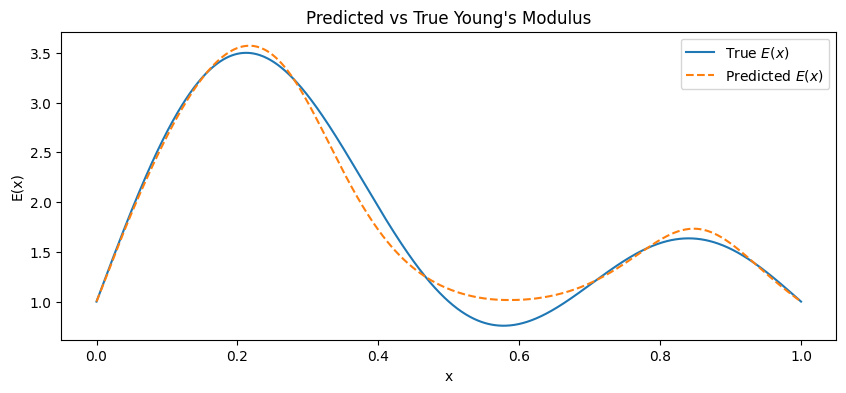

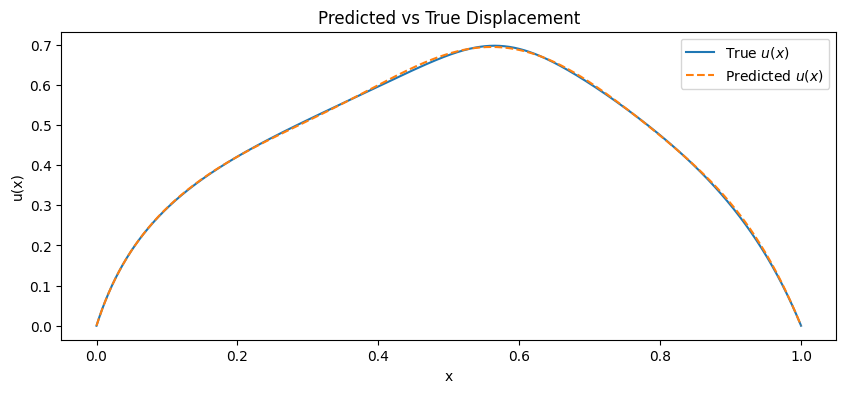

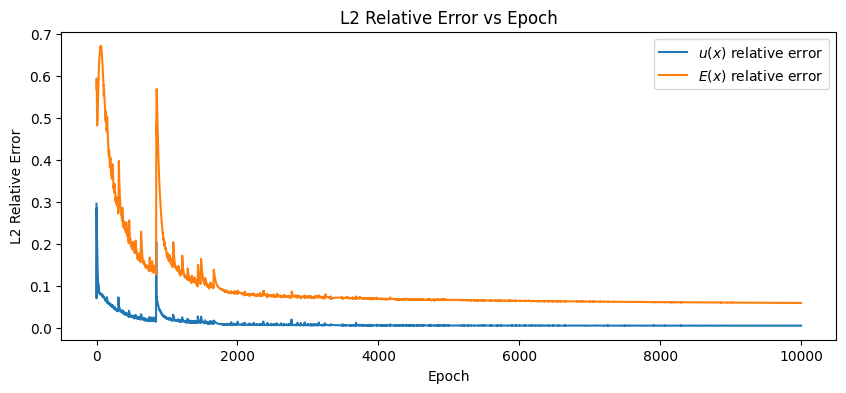

In [143]:
mollifier = Mollifier()

# Predict Young's modulus and displacement on the test set
with torch.no_grad():
    e_pred = model_e(x_test)
    e_pred = mollifier.apply_e(e_pred, x_test).cpu()
    u_pred = model_u(x_test)
    u_pred = mollifier.apply_u(u_pred, x_test).cpu()

# Plot Young's modulus prediction vs ground truth
plt.figure(figsize=(10, 4))
plt.plot(x_test.cpu().numpy(), e_test.cpu().numpy(), label='True $E(x)$')
plt.plot(x_test.cpu().numpy(), e_pred.numpy(), '--', label='Predicted $E(x)$')
plt.xlabel('x')
plt.ylabel('E(x)')
plt.legend()
plt.title('Predicted vs True Young\'s Modulus')
plt.show()

# Plot displacement prediction vs ground truth
plt.figure(figsize=(10, 4))
plt.plot(x_test.cpu().numpy(), u_test.cpu().numpy(), label='True $u(x)$')
plt.plot(x_test.cpu().numpy(), u_pred.numpy(), '--', label='Predicted $u(x)$')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Predicted vs True Displacement')
plt.show()

# Plot L2 relative error for displacement and Young's modulus over epochs
plt.figure(figsize=(10, 4))
plt.plot(error_u_list, label='$u(x)$ relative error')
plt.plot(error_e_list, label='$E(x)$ relative error')
plt.xlabel('Epoch')
plt.ylabel('L2 Relative Error')
plt.title('L2 Relative Error vs Epoch')
plt.legend()
plt.show()
